In [1]:
%matplotlib inline

import glob
from string import letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import signal
from sklearn.decomposition import PCA

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


The first step is to find which rows of the locations df correspond to differentially bound regions. 

We start by loading the locations dataset

In [2]:
locations_df=pd.read_csv("20160804LocationsWithChromatinState")
locations_df.columns = ["a", "chr","start","end","chromatin_state"]
del locations_df["a"]
locations_df.head()

,chr,start,end,chromatin_state
0,211000022278049,390,394,NaN
1,211000022278049,537,541,NaN
2,211000022278049,573,577,NaN
3,211000022278049,837,841,NaN
4,211000022278049,1613,1617,NaN


The following dataframe of differentially expressed genes for carcass was created in 20160731_Including_heterochromatic_state.ipynb

In [4]:
diff_expression_df=pd.read_csv("Differentially_expressed_genes_carcass_df")
diff_expression_df.head()

,Unnamed: 0,chr,start,end
0,0,X,245978,254650
1,1,X,585081,620195
2,2,X,946662,947500
3,3,X,2278031,2293411
4,4,X,2622069,2624575


Now we want to find which locations are differentially expressed

In [ ]:
locations_df["contains_diff_expressed"]=[0 for ele in locations_df['chr']]
for i,row1 in enumerate(diff_expression_df.iterrows()):
    print i,
    key = str(row1[1]['chr'])     
    subset_chrom_df=locations_df[locations_df.chr == key]
    len_subset_chrom_df = subset_chrom_df.shape[0]
    for j in range(len_subset_chrom_df):
        try:
            if float(row1[1]['end']) >= float(subset_chrom_df.loc[subset_chrom_df.index[j],'end']) and float(row1[1]['start']) <= float(subset_chrom_df.loc[subset_chrom_df.index[j],'start']) :
                #print list(row1[1]), subset_chrom_df.index[j]
                
                locations_df.ix[subset_chrom_df.index[j], 'contains_diff_expressed']=str(list(row1[1]))
                    #diff_expression_df.ix[i,'chromatin_state'] = subset_chrom_df.ix[subset_chrom_df.index[j],'chromatin']
        except:
            pass

0 1 

In [33]:
locations_df.ix[310020,]

chr                                               X
start                                        250162
end                                          250166
contains_diff_expressed    [0, 'X', 245978, 254650]
Name: 310020, dtype: object

In [7]:
locations_df[locations_df.contains_diff_expressed!=0].tail()

,chr,start,end,contains_diff_expressed
373894,X,22534746,22534750,"[298, 'X', 22529964, 22536371]"
373895,X,22535316,22535320,"[298, 'X', 22529964, 22536371]"
373896,X,22535972,22535976,"[298, 'X', 22529964, 22536371]"
373897,X,22536070,22536074,"[298, 'X', 22529964, 22536371]"
373898,X,22536273,22536277,"[298, 'X', 22529964, 22536371]"


In [8]:
#locations_df.to_csv("locations_df_with_diff_expressed", sep=";")

In [4]:
locations_df=pd.read_csv("locations_df_with_diff_expressed",sep=';')

In [5]:
locations_df.head()
len(locations_df)

,Unnamed: 0,chr,start,end,contains_diff_expressed
0,0,211000022278049,390,394,0
1,1,211000022278049,537,541,0
2,2,211000022278049,573,577,0
3,3,211000022278049,837,841,0
4,4,211000022278049,1613,1617,0


In [13]:
locations_df[locations_df.contains_diff_expressed!='0'].groupby("chr").count()

,Unnamed: 0,start,end,contains_diff_expressed
chr,,,,
2L,2016,2016,2016,2016
2R,2437,2437,2437,2437
3L,3404,3404,3404,3404
3R,2572,2572,2572,2572
4,63,63,63,63
X,3128,3128,3128,3128


Restricting locations to avoid various scaffolding chromos

In [14]:
locations_df_restricted=locations_df[locations_df["chr"].isin(["X", "2L","2R","3L","3R","4"])]

Now we want to find which locations are differentially bound

In [6]:
lpadj=[]
lpval=[]
for f1 in glob.glob("nbin*"):
    df_padj = pd.read_csv(f1).padj
    df_pval = pd.read_csv(f1).pvalue
    lpadj.append(df_padj)
    lpval.append(df_pval)
pval = pd.concat(lpval, axis = 1)
padj = pd.concat(lpadj, axis = 1)

pval.columns= map(lambda x: x[25:], glob.glob("nbin*"))
pval.head()

padj.columns= map(lambda x: x[25:], glob.glob("nbin*"))
padj.head()

,C_D1,C_Lam,T_D1,T_Lam,W_D1,W_Lam
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
len(pval)

388464

In [17]:
pval_restricted=pval[locations_df["chr"].isin(["X", "2L","2R","3L","3R","4"])]
padj_restricted=padj[locations_df["chr"].isin(["X", "2L","2R","3L","3R","4"])]
len(pval_restricted)                                   

373635

In [24]:
print "Mean adjusted p-vals for differential binding conditioning on non diff expressed gene locations"
print padj_restricted[locations_df_restricted.contains_diff_expressed=='0'].mean()
print "conditioning on diff expressed gene locations"
print padj_restricted[locations_df_restricted.contains_diff_expressed!='0'].mean()

Mean adjusted p-vals for differential binding conditioning on non diff expressed gene locations
C_D1     0.596065
C_Lam    0.407058
T_D1     0.381600
T_Lam    0.493401
W_D1     0.985435
W_Lam    0.936127
dtype: float64
conditioning on diff expressed gene locations
C_D1     0.610274
C_Lam    0.386429
T_D1     0.416556
T_Lam    0.490505
W_D1     0.986447
W_Lam    0.946208
dtype: float64


In [23]:
print "Mean p-vals for differential binding conditioning on non diff expressed gene locations"
print pval_restricted[locations_df_restricted.contains_diff_expressed=='0'].mean()
print "conditioning on diff expressed gene locations"
print pval_restricted[locations_df_restricted.contains_diff_expressed!='0'].mean()

Mean p-vals for differential binding conditioning on non diff expressed gene locations
C_D1     0.509445
C_Lam    0.341489
T_D1     0.599716
T_Lam    0.436740
W_D1     0.544637
W_Lam    0.547987
dtype: float64
conditioning on diff expressed gene locations
C_D1     0.490584
C_Lam    0.299476
T_D1     0.573320
T_Lam    0.409605
W_D1     0.544514
W_Lam    0.550403
dtype: float64


plots of the p-vals (testing differential binding in different protein by tissue combos)


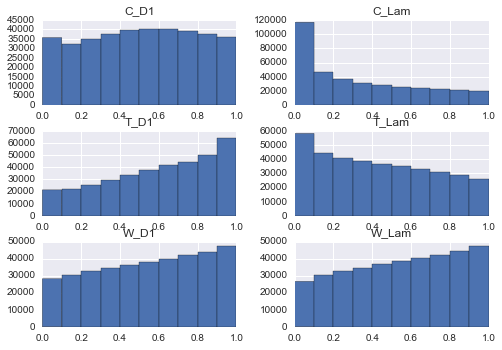

plots of the p-adj (testing differential binding in different protein by tissue combos)


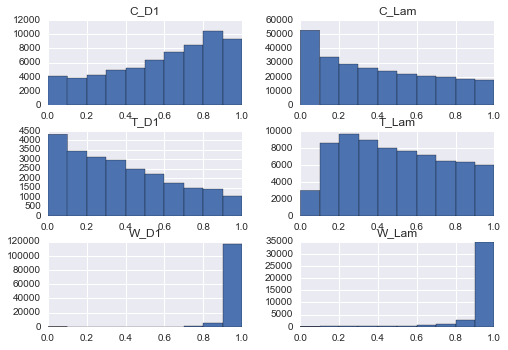

In [22]:
print "plots of the p-vals (testing differential binding in different protein by tissue combos)"
_=pval_restricted.hist()
plt.show()
print "plots of the p-adj (testing differential binding in different protein by tissue combos)"
_=padj_restricted.hist()

The hist of the p-adj look very different from the plots of the pvals.  Tim: which should I be looking at?

p-adj (testing differential binding in different protein by tissue combos) for non diff expressed genes


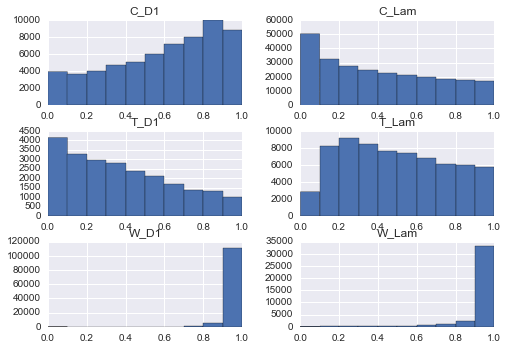

p-adj (testing differential binding in different protein by tissue combos) for diff expressed genes


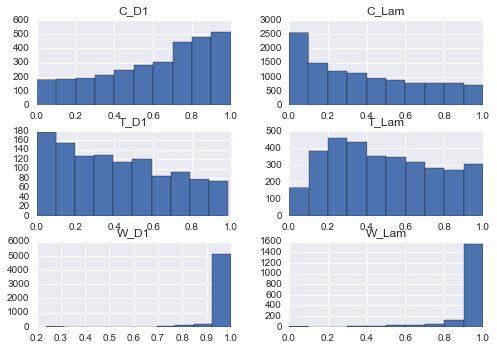

In [26]:
print "p-adj (testing differential binding in different protein by tissue combos) for non diff expressed genes"
_=padj_restricted[locations_df_restricted.contains_diff_expressed=='0'].hist()
plt.show()
print "p-adj (testing differential binding in different protein by tissue combos) for diff expressed genes"
_=padj_restricted[locations_df_restricted.contains_diff_expressed!='0'].hist()


you can't really see a difference between the shapes of these distributions

p-val (testing differential binding in different protein by tissue combos) for non diff expressed genes


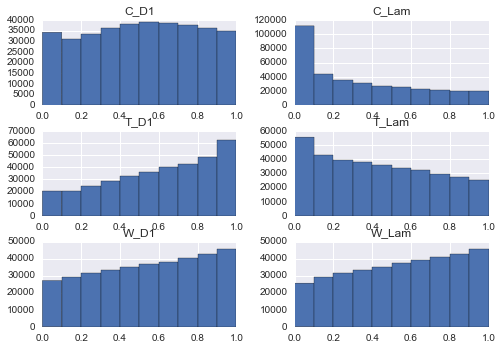

p-val (testing differential binding in different protein by tissue combos) for diff expressed genes


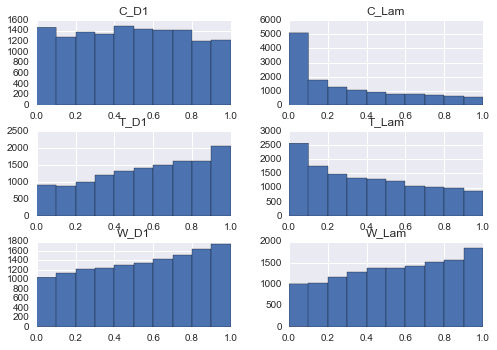

In [28]:
print "p-val (testing differential binding in different protein by tissue combos) for non diff expressed genes"
_=pval_restricted[locations_df_restricted.contains_diff_expressed=='0'].hist()
plt.show()
print "p-val (testing differential binding in different protein by tissue combos) for diff expressed genes"
_=pval_restricted[locations_df_restricted.contains_diff_expressed!='0'].hist()



shapes are pretty consistent.  We're going to run a 2-sample Kolmogorov-Smirnov test though to test whether they are actually different (mean p-values look lower for the significant binding, which is what we would expect).

In [30]:
import scipy.stats
print "tissue_protein, not diff expressed mean diff binding p-val, diff expressed mean diff binding p-val"
for col in pval.columns:
    print col, pval_restricted[locations_df_restricted.contains_diff_expressed=='0'][col].mean(), pval_restricted[locations_df_restricted.contains_diff_expressed!='0'][col].mean()
    print "Larger p-val for diff expressed?", pval_restricted[locations_df_restricted.contains_diff_expressed=='0'][col].mean() < pval_restricted[locations_df_restricted.contains_diff_expressed!='0'][col].mean()
    print scipy.stats.ks_2samp(pval_restricted[locations_df_restricted.contains_diff_expressed=='0'][col], pval_restricted[locations_df_restricted.contains_diff_expressed!='0'][col])

tissue_protein, not diff expressed mean diff binding p-val, diff expressed mean diff binding p-val
C_D1 0.509444529537 0.490583554236
Larger p-val for diff expressed? False
Ks_2sampResult(statistic=0.03001952745361014, pvalue=1.016061203738003e-10)
C_Lam 0.341488764429 0.299476024508
Larger p-val for diff expressed? False
Ks_2sampResult(statistic=0.069123992080359298, pvalue=5.2526274971516148e-55)
T_D1 0.599716162993 0.573319928554
Larger p-val for diff expressed? False
Ks_2sampResult(statistic=0.040387352925395192, pvalue=4.6611981349547103e-19)
T_Lam 0.436740128113 0.409604729781
Larger p-val for diff expressed? False
Ks_2sampResult(statistic=0.046379048327709782, pvalue=5.369331217454405e-25)
W_D1 0.544637058793 0.54451354959
Larger p-val for diff expressed? False
Ks_2sampResult(statistic=0.0072042978385445378, pvalue=0.50219235211644964)
W_Lam 0.547986807346 0.550403251711
Larger p-val for diff expressed? True
Ks_2sampResult(statistic=0.012166324934698936, pvalue=0.040756452959817

In [31]:
for col in padj.columns:
    print col, 
    print padj_restricted[locations_df.contains_diff_expressed=='0'][col].mean(), padj_restricted[locations_df.contains_diff_expressed!='0'][col].mean()
    print "Larger p-val for diff expressed?", padj_restricted[locations_df.contains_diff_expressed=='0'][col].mean() < padj_restricted[locations_df.contains_diff_expressed!='0'][col].mean()
    print scipy.stats.ks_2samp(padj_restricted[locations_df.contains_diff_expressed=='0'][col], padj_restricted[locations_df.contains_diff_expressed!='0'][col])

C_D1 0.596065180058 0.610274157102
Larger p-val for diff expressed? True
Ks_2sampResult(statistic=0.052326080882214826, pvalue=1.0582175140088814e-31)
C_Lam 0.407058137543 0.386429452048
Larger p-val for diff expressed? False
Ks_2sampResult(statistic=0.12168098600394839, pvalue=1.4747992967610224e-169)
T_D1 0.381599511679 0.416555969511
Larger p-val for diff expressed? True
Ks_2sampResult(statistic=0.020815456722587611, pvalue=2.247113259694364e-05)
T_Lam 0.493401218217 0.490504942035
Larger p-val for diff expressed? False
Ks_2sampResult(statistic=0.05302011094618489, pvalue=1.5466730252145288e-32)
W_D1 0.985435204619 0.986447351386
Larger p-val for diff expressed? True
Ks_2sampResult(statistic=0.072029087016136917, pvalue=1.0869656872474462e-59)
W_Lam 0.936126934545 0.946208175356
Larger p-val for diff expressed? True
Ks_2sampResult(statistic=0.024636990468030542, pvalue=2.3306001249824555e-07)


The p-val results are consistent with what we would expect.  the adjusted p-val results are not

In [26]:
locations_df[locations_df.contains_diff_expressed!=0].tail(n=10)

,chr,start,end,contains_diff_expressed
373889,X,22533068,22533072,"[298, 'X', 22529964, 22536371]"
373890,X,22533108,22533112,"[298, 'X', 22529964, 22536371]"
373891,X,22533257,22533261,"[298, 'X', 22529964, 22536371]"
373892,X,22533415,22533419,"[298, 'X', 22529964, 22536371]"
373893,X,22533864,22533868,"[298, 'X', 22529964, 22536371]"
373894,X,22534746,22534750,"[298, 'X', 22529964, 22536371]"
373895,X,22535316,22535320,"[298, 'X', 22529964, 22536371]"
373896,X,22535972,22535976,"[298, 'X', 22529964, 22536371]"
373897,X,22536070,22536074,"[298, 'X', 22529964, 22536371]"
373898,X,22536273,22536277,"[298, 'X', 22529964, 22536371]"


The KS test tells us that the distribution of the bindings in the populations (conditioning on whether or not region contains differentially expressed genes) is different.  This means that location and shape are different, but we don't actually care about shape.  So we're going to do a Mann-Whitney test, to test whether or not just the location is different.

In [39]:
print "P-Adj"
print
for col in padj_restricted.columns:
    print col, 
    print padj_restricted[locations_df.contains_diff_expressed=='0'][col].mean(), padj_restricted[locations_df.contains_diff_expressed!='0'][col].mean()
    print "Larger p-val for diff expressed?", padj_restricted[locations_df.contains_diff_expressed=='0'][col].mean() < padj_restricted[locations_df.contains_diff_expressed!='0'][col].mean()
    print scipy.stats.ks_2samp(padj_restricted[locations_df.contains_diff_expressed=='0'][col], padj_restricted[locations_df.contains_diff_expressed!='0'][col])
    print scipy.stats.mannwhitneyu(padj_restricted[locations_df.contains_diff_expressed=='0'][col], padj_restricted[locations_df.contains_diff_expressed!='0'][col], use_continuity=True,)
    print 

P-Adj

C_D1 0.596065180058 0.610274157102
Larger p-val for diff expressed? True
Ks_2sampResult(statistic=0.052326080882214826, pvalue=1.0582175140088814e-31)
MannwhitneyuResult(statistic=1569632299.5, pvalue=0.0)

C_Lam 0.407058137543 0.386429452048
Larger p-val for diff expressed? False
Ks_2sampResult(statistic=0.12168098600394839, pvalue=1.4747992967610224e-169)
MannwhitneyuResult(statistic=2034017993.0, pvalue=8.6738146785913039e-251)

T_D1 0.381599511679 0.416555969511
Larger p-val for diff expressed? True
Ks_2sampResult(statistic=0.020815456722587611, pvalue=2.247113259694364e-05)
MannwhitneyuResult(statistic=1575247142.5, pvalue=0.0)

T_Lam 0.493401218217 0.490504942035
Larger p-val for diff expressed? False
Ks_2sampResult(statistic=0.05302011094618489, pvalue=1.5466730252145288e-32)
MannwhitneyuResult(statistic=1236009705.0, pvalue=0.0)

W_D1 0.985435204619 0.986447351386
Larger p-val for diff expressed? True
Ks_2sampResult(statistic=0.072029087016136917, pvalue=1.08696568724744

In [40]:
print "Pval"
print
for col in pval_restricted.columns:
    print col, 
    print pval_restricted[locations_df.contains_diff_expressed=='0'][col].mean(), pval_restricted[locations_df.contains_diff_expressed!='0'][col].mean()
    print "Larger p-val for diff expressed?", pval_restricted[locations_df.contains_diff_expressed=='0'][col].mean() < pval_restricted[locations_df.contains_diff_expressed!='0'][col].mean()
    print scipy.stats.ks_2samp(pval_restricted[locations_df.contains_diff_expressed=='0'][col], pval_restricted[locations_df.contains_diff_expressed!='0'][col])
    print scipy.stats.mannwhitneyu(pval_restricted[locations_df.contains_diff_expressed=='0'][col], pval_restricted[locations_df.contains_diff_expressed!='0'][col], use_continuity=True,)
    print 

Pval

C_D1 0.509444529537 0.490583554236
Larger p-val for diff expressed? False
Ks_2sampResult(statistic=0.03001952745361014, pvalue=1.016061203738003e-10)
MannwhitneyuResult(statistic=2358751954.0, pvalue=2.6849640515284523e-14)

C_Lam 0.341488764429 0.299476024508
Larger p-val for diff expressed? False
Ks_2sampResult(statistic=0.069123992080359298, pvalue=5.2526274971516148e-55)
MannwhitneyuResult(statistic=2234225095.5, pvalue=1.2156960697723128e-69)

T_D1 0.599716162993 0.573319928554
Larger p-val for diff expressed? False
Ks_2sampResult(statistic=0.040387352925395192, pvalue=4.6611981349547103e-19)
MannwhitneyuResult(statistic=2323787090.5, pvalue=2.0416161370001593e-25)

T_Lam 0.436740128113 0.409604729781
Larger p-val for diff expressed? False
Ks_2sampResult(statistic=0.046379048327709782, pvalue=5.369331217454405e-25)
MannwhitneyuResult(statistic=2312900429.5, pvalue=1.3971331308569726e-29)

W_D1 0.544637058793 0.54451354959
Larger p-val for diff expressed? False
Ks_2sampResult

MannWhitney tests behave about as you would expect for pval (not really for p-adj)

## Things to do 

Look at some measure of effect size.  Instead of treating differential expression as binary expressed and not expressed, do actual correlation of p-values.  Correlation of p-values against p-values.

Is higher binding associated with lower expression.  

There are a set of genes that have TATA boxes, particular element in core promoter.  Supposedly genes that have TATA boxes are particularly sensitive to environmental perturbations.

Are genes with TATA boxes particularly sensitive to local chromatin state.  Genes with TATA boxes-- are they more likely to be YRV genes?  Are they more likely to be near regions of differential binding.

Same Mann-Whitney test as above, but now question is does have TATA box or not have TATA box? Find list of Drosophila genes with TATA box info.


1) Correlation of p-values
2) Look up TATA box situation.